In [1]:
!pip install -q transformers datasets evaluate


In [2]:
!pip install --upgrade transformers



: 

In [2]:
%env CUDA_VISIBLE_DEVICES

'6'

In [3]:
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [4]:
%env CUDA_VISIBLE_DEVICES

'0'

In [5]:
import os
import torch
import numpy as np
import json
import matplotlib.pyplot as plt

In [6]:
from structures.dataset_structure import COCOSegmentationDataset
from utils.data_preprocessor_utils import *
from utils.visualize_utils import *

In [7]:
datadir = "./data/car-parts-and-car-damages/"
carparts_dir = os.path.join(datadir,"Car_parts_dataset")
cardamages_dir = os.path.join(datadir,"Car_damages_dataset")
carparts_imgs = os.path.join(carparts_dir,"split_dataset")
carparts_anns = os.path.join(carparts_dir,"split_annotations")
cardamages_imgs = os.path.join(cardamages_dir,"split_dataset")
cardamages_anns = os.path.join(cardamages_dir,"split_annotations")

In [8]:
cardamage_id_to_color = get_colormapping(cardamages_dir+"/coco_damage_annotations.json",cardamages_dir+"/meta.json")
carpart_id_to_color = get_colormapping(carparts_dir+"/coco_parts_annotations.json",carparts_dir+"/meta.json")
cardamage_id_to_color,carpart_id_to_color,len(carpart_id_to_color)

loading annotations into memory...
Done (t=0.28s)
creating index...
index created!
loading annotations into memory...
Done (t=0.61s)
creating index...
index created!


({3: '#13A4C9',
  2: '#A6FF47',
  6: '#B42D38',
  8: '#E19660',
  1: '#903C59',
  7: '#A7741B',
  4: '#B40E13',
  5: '#73C2CE'},
 {16: '#5C7529',
  2: '#40993D',
  12: '#913021',
  20: '#E5F83A',
  8: '#FE2FC0',
  15: '#C19744',
  3: '#E62D30',
  7: '#E95353',
  9: '#903765',
  13: '#9A87CF',
  4: '#320698',
  14: '#8206DB',
  21: '#963C3D',
  1: '#4355CB',
  6: '#D50BB4',
  18: '#2E7F62',
  17: '#90D092',
  5: '#4AF778',
  19: '#7C93DA',
  10: '#BC574E',
  11: '#87DB00'},
 21)

In [9]:
# Create dataset
train_cardamage_dataset = get_dataset(cardamages_imgs,cardamages_anns,is_train=True)
val_cardamage_dataset = get_dataset(cardamages_imgs,cardamages_anns)


root  ./data/car-parts-and-car-damages/Car_damages_dataset/split_dataset/train
ann_file  ./data/car-parts-and-car-damages/Car_damages_dataset/split_annotations/train.json
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
root  ./data/car-parts-and-car-damages/Car_damages_dataset/split_dataset/val
ann_file  ./data/car-parts-and-car-damages/Car_damages_dataset/split_annotations/val.json
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [34]:
# Check an example
image, mask = train_cardamage_dataset[190]
print(image.shape, mask.shape,train_cardamage_dataset.img_path)  # Tensor dimensions

torch.Size([3, 594, 800]) torch.Size([1, 594, 800]) ./data/car-parts-and-car-damages/Car_damages_dataset/split_dataset/train/Car damages 857.jpg


In [35]:
# with open('./mask.txt', 'w') as f:
#     for m in mask.numpy()[0]:
#         f.write("%s\n" % m)

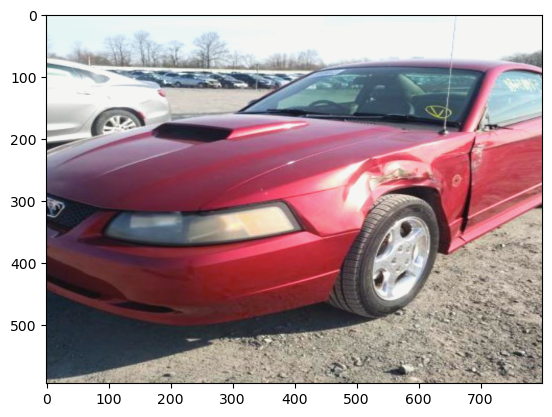

In [36]:
plt.imshow(unnormalize_image(image.transpose(0,-1).transpose(0,1).numpy()))

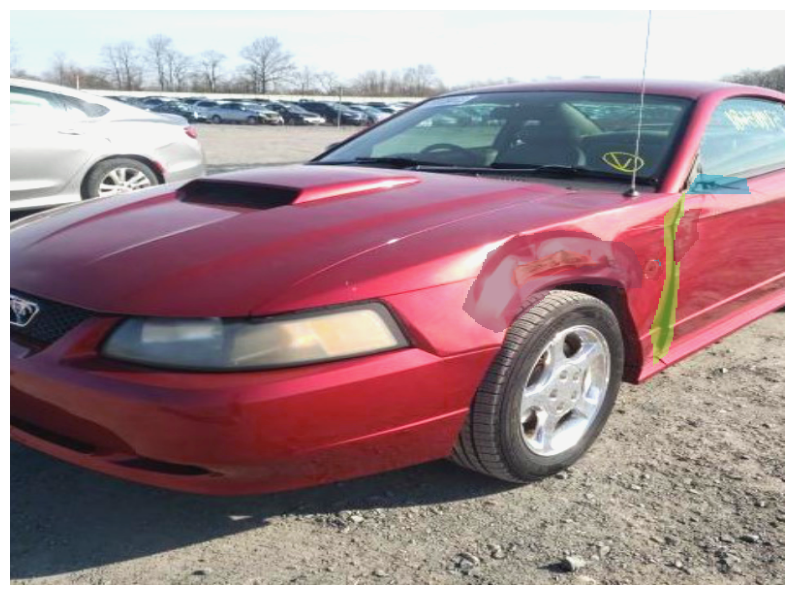

In [37]:
overlayed_image = overlay_colored_mask(image.transpose(0,-1).transpose(0,1).numpy(), mask[0].numpy(), cardamage_id_to_color, alpha=0.5)

# Visualize the result
plt.figure(figsize=(10, 10))
plt.imshow(overlayed_image)
plt.axis('off')
plt.show()

In [12]:
from torch.utils.data import DataLoader

# Create DataLoader
tr_cd_dataloader = DataLoader(train_cardamage_dataset, batch_size=2, shuffle=True)
val_cd_dataloader = DataLoader(val_cardamage_dataset, batch_size=2)

In [15]:
from transformers import SegformerFeatureExtractor, SegformerForSemanticSegmentation
from PIL import Image
from cardamage_segmentation import get_segformermodel,get_model_from_path,evaluate_model

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

2025-01-01 00:40:59.365864: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-01 00:41:00.419736: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/akshay/.conda/envs/research-work-DAG-DNN/lib/python3.7/site-packages/cv2/../../lib64:
2025-01-01 00:41:00.419831: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/akshay/.conda/envs/research-work

In [64]:
# pretrained_model_name = "nvidia/segformer-b3-finetuned-cityscapes-1024-1024"
pretrained_model_name = "nvidia/segformer-b5-finetuned-ade-640-640"
start_net_path="./checkpoints/contrast1/nvidia_segformer-b5-finetuned-ade-640-640_ep_23.pt"
model = get_segformermodel(len(cardamage_id_to_color),pretrained_model_name)
model,_,_,_ = get_model_from_path(model,None,None,start_net_path)


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b5-finetuned-ade-640-640 and are newly initialized because the shapes did not match:
- decode_head.classifier.weight: found shape torch.Size([150, 768, 1, 1]) in the checkpoint and torch.Size([9, 768, 1, 1]) in the model instantiated
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([9]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Checkpoint loaded from ./checkpoints/contrast1/nvidia_segformer-b5-finetuned-ade-640-640_ep_23.pt


In [65]:
evaluate_model(model.cuda(),len(cardamage_id_to_color),val_cd_dataloader)

Evaluating:   0%|          | 0/82 [00:00<?, ?it/s]/home/akshay/.conda/envs/research-work-DAG-DNN/lib/python3.7/site-packages/datasets/features/image.py:334: UserWarning: Downcasting array dtype int64 to int32 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")
/home/akshay/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/9e450724f21f05592bfb0255fe2fa576df8171fa060d11121d8aecfff0db80d0/mean_iou.py:259: RuntimeWarning: invalid value encountered in true_divide
  iou = total_area_intersect / total_area_union
/home/akshay/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/9e450724f21f05592bfb0255fe2fa576df8171fa060d11121d8aecfff0db80d0/mean_iou.py:260: RuntimeWarning: invalid value encountered in true_divide
  acc = total_area_intersect / total_area_label
Evaluating:   1%|          | 1/82 [00:01<01:53,  1.40s/it]/home/akshay/.conda/envs/research-work-DAG-DNN/

Validation loss: 0.2532703926014464 mean_iou :0.3447728633078067, mean_accuracy :0.431931472007721 val_pixel_accuracy: 0.9342586433440092 val_dice_coeff : 0.5404521822929382


(0.2532703926014464,
 0.3447728633078067,
 0.431931472007721,
 0.9342586433440092,
 tensor(0.5405))

In [66]:
evaluate_model(model.cuda(),len(cardamage_id_to_color),tr_cd_dataloader)

Evaluating:   0%|          | 0/326 [00:00<?, ?it/s]/home/akshay/.conda/envs/research-work-DAG-DNN/lib/python3.7/site-packages/datasets/features/image.py:334: UserWarning: Downcasting array dtype int64 to int32 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")
/home/akshay/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/9e450724f21f05592bfb0255fe2fa576df8171fa060d11121d8aecfff0db80d0/mean_iou.py:259: RuntimeWarning: invalid value encountered in true_divide
  iou = total_area_intersect / total_area_union
/home/akshay/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/9e450724f21f05592bfb0255fe2fa576df8171fa060d11121d8aecfff0db80d0/mean_iou.py:260: RuntimeWarning: invalid value encountered in true_divide
  acc = total_area_intersect / total_area_label
Evaluating:   0%|          | 1/326 [00:01<07:48,  1.44s/it]/home/akshay/.conda/envs/research-work-DAG-DN

Validation loss: 0.10955791425051316 mean_iou :0.5158412720831441, mean_accuracy :0.5671555759147914 val_pixel_accuracy: 0.9722211313028039 val_dice_coeff : 0.6920034885406494


(0.10955791425051316,
 0.5158412720831441,
 0.5671555759147914,
 0.9722211313028039,
 tensor(0.6920))

In [14]:
iter_train = iter(tr_cd_dataloader)

In [15]:
img,msk = next(iter_train)
img.size(),msk.size()

(torch.Size([2, 3, 594, 800]), torch.Size([2, 1, 594, 800]))

In [16]:
import torch.nn.functional as F
msk=msk.squeeze(1)
model = model.cpu()
outputs = model(img,msk)
logits = outputs.logits
with torch.no_grad():
    upsampled_logits = F.interpolate(logits, size=msk.shape[-2:], mode="bilinear", align_corners=False)
    predicted = upsampled_logits.argmax(dim=1)


NameError: name 'model' is not defined

In [70]:
predicted.size(),msk.size(),upsampled_logits.size(),logits.size(),img.size()

(torch.Size([2, 594, 800]),
 torch.Size([2, 594, 800]),
 torch.Size([2, 9, 594, 800]),
 torch.Size([2, 9, 149, 200]),
 torch.Size([2, 3, 594, 800]))

In [18]:
ind=0

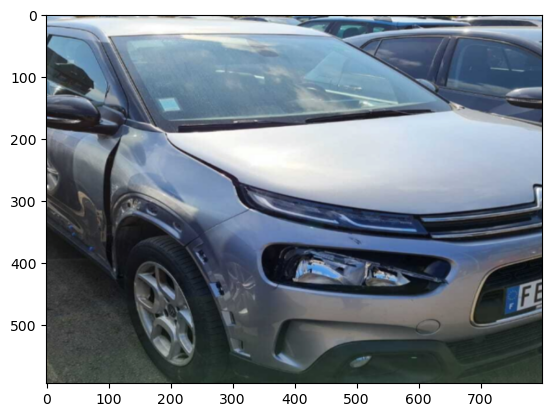

In [19]:
plt.imshow(unnormalize_image(img[ind].transpose(0,-1).transpose(0,1).numpy()))

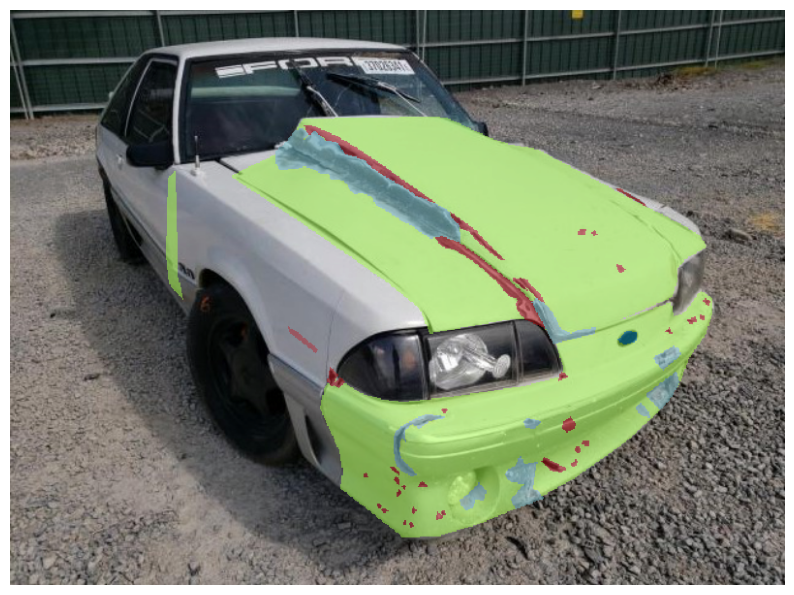

In [73]:
overlayed_image = overlay_colored_mask(img[ind].transpose(0,-1).transpose(0,1).numpy(), msk[ind].numpy(), cardamage_id_to_color, alpha=0.5)

# Visualize the result
plt.figure(figsize=(10, 10))
plt.imshow(overlayed_image)
plt.axis('off')
plt.show()

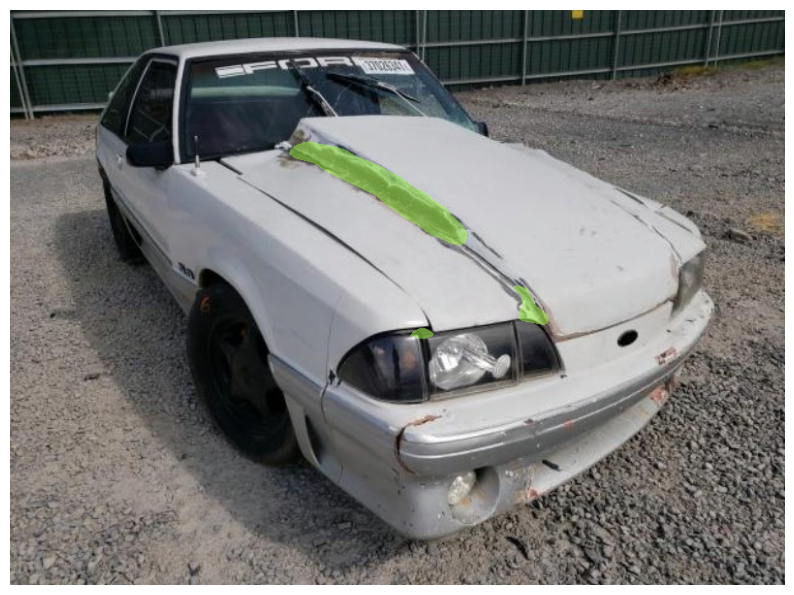

: 

In [74]:
overlayed_image = overlay_colored_mask(img[ind].transpose(0,-1).transpose(0,1).numpy(), predicted[ind].numpy(), cardamage_id_to_color, alpha=0.5)

# Visualize the result
plt.figure(figsize=(10, 10))
plt.imshow(overlayed_image)
plt.axis('off')
plt.show()

In [23]:
with open('./mask.txt', 'w') as f:
    for m in msk.numpy()[0]:
        f.write("%s\n" % m)

with open('./pred.txt', 'w') as f:
    for m in predicted.numpy()[0]:
        f.write("%s\n" % m)

2024-12-30 01:22:32.797693: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer.so.6'; dlerror: libnvinfer.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/akshay/.conda/envs/research-work-DAG-DNN/lib/python3.7/site-packages/cv2/../../lib64:
2024-12-30 01:22:32.797803: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer_plugin.so.6'; dlerror: libnvinfer_plugin.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/akshay/.conda/envs/research-work-DAG-DNN/lib/python3.7/site-packages/cv2/../../lib64:
2024-12-30 01:22:32.797814: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:30] Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
/home/akshay/.conda/envs/research-work-DAG-DNN/lib/python3.7/

inputs  torch.Size([1, 3, 1024, 1024])
logits  torch.Size([1, 19, 256, 256])


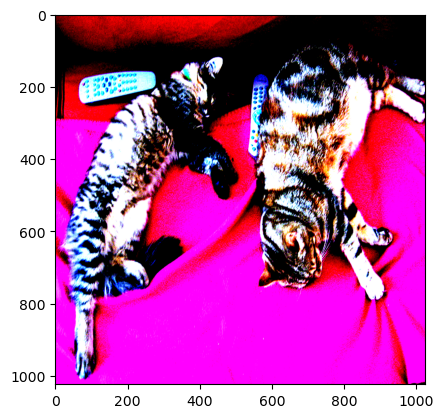

In [18]:
# from transformers import SegformerFeatureExtractor, SegformerForSemanticSegmentation
# from PIL import Image
# import requests

# feature_extractor = SegformerFeatureExtractor.from_pretrained("nvidia/segformer-b5-finetuned-cityscapes-1024-1024")
# model = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b5-finetuned-cityscapes-1024-1024")

# url = "http://images.cocodataset.org/val2017/000000039769.jpg"
# image = Image.open(requests.get(url, stream=True).raw)
# inputs = feature_extractor(images=image, return_tensors="pt")
# print("inputs ",inputs["pixel_values"].shape)
# plt.imshow(inputs["pixel_values"][0].transpose(0,-1).transpose(0,1).numpy())
# outputs = model(**inputs)
# logits = outputs.logits  # shape (batch_size, num_labels, height/4, width/4)
# print("logits ",logits.size())